# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Looking in indexes: https://download.pytorch.org/whl/cu118


In [25]:
import torch

# define the hyperparameters
BATCH_SIZE = 1024          #usually a number that is a power of 2 is chosen for the batch size because it is more efficient for the GPU
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [26]:
#we nee to import torchvision to load the MNIST dataset
import torchvision
#we need to import DataLoader to load the data in batches
from torch.utils.data import DataLoader


transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

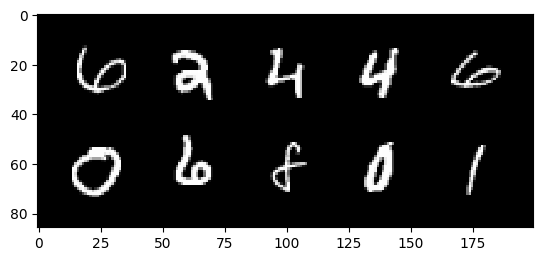

In [27]:
from training_utils import visualize_images

visualize_images(train_dataloader)

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [29]:
from training_utils import fit
from training_utils import predict

# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.5194903733366627
Epoch 1: Loss=0.46563439955145625
Epoch 2: Loss=0.2696152786582203
Epoch 3: Loss=0.20317487544932608
Epoch 4: Loss=0.16814565759594158
Epoch 5: Loss=0.14524164707478832
Epoch 6: Loss=0.12652455270290375
Epoch 7: Loss=0.11672015563916352
Epoch 8: Loss=0.10599584839606689
Epoch 9: Loss=0.09819453367489879
Test set: Avg. loss: 0.0945, Accuracy: 9715/10000 (97%)


(0.09449142074584961, tensor(97.1500, device='cuda:0'))

## CIFAR10

In [30]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


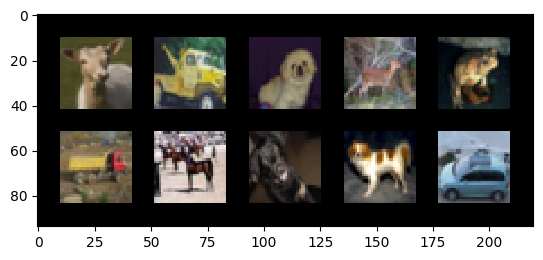

In [31]:
visualize_images(train_dataloader)

In [32]:
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, #COLORED IMAGES!
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10) #Now is 32x32 images!

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn_cifar,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=2.221339678277775
Epoch 1: Loss=2.1187497693665174
Epoch 2: Loss=2.0365099225725447
Epoch 3: Loss=1.9294477701187134
Epoch 4: Loss=1.8544620397139568
Epoch 5: Loss=1.7782296282904488
Epoch 6: Loss=1.7057102529370054
Epoch 7: Loss=1.6475430386407035
Epoch 8: Loss=1.5947820994318749
Epoch 9: Loss=1.5529618238916203
Test set: Avg. loss: 1.5895, Accuracy: 4260/10000 (43%)


(1.589457568359375, tensor(42.6000, device='cuda:0'))

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set (HERE WE GO BACK TO MNIST)

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [33]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [34]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

**Question** Modify the fit function to also use a validation set.

In [35]:
#---------OLD FIT FUNCTION----------------

#def fit(model: nn.Module,train_dataloader: DataLoader,optimizer: torch.optim.Optimizer, epochs: int,device: torch.device,):
#    """
#    the fit method simply calls the train_epoch() method for a
#    specified number of epochs.
#    """

    # keep track of the losses in order to visualize them later
#    losses = []
#    for epoch in range(epochs):
#        running_loss = train_epoch(
#            model=model,
#            train_dataloader=train_dataloader,
#            optimizer=optimizer,
#            device=device,
#        )
#        print(f"Epoch {epoch}: Loss={running_loss}")
#        losses.append(running_loss)

#    return losses

#---------NEW FIT FUNCTION----------------

def fit(model: nn.Module, train_dataloader: DataLoader, valid_dataloader: DataLoader, optimizer: torch.optim.Optimizer, num_epochs: int, device: torch.device):

    # we need two extra metrics to keep track of the validation loss and accuracy
    training_losses, validation_losses, validation_accuracies = [], [], []

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        train_loss = train_epoch(model=model, train_dataloader=train_dataloader, optimizer=optimizer, device=device)

        #evaluate the model on the validation set
        val_loss, val_accuracy = predict(model, valid_dataloader, device, verbose=False)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)

        #print progress
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    
    return training_losses, validation_losses, validation_accuracies


## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

### Learning rate
**Question** Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

In [36]:
cnn = CNN().to(DEVICE)

opt = torch.optim.SGD(cnn.parameters(), lr=0.001)

train_losses, valid_losses, valid_accs = fit(model=cnn, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, optimizer=opt, num_epochs=10, device=DEVICE)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 1: Train Loss = 2.3073, Val Loss = 2.3033, Val Accuracy = 6.7500
Epoch 2: Train Loss = 2.3003, Val Loss = 2.2966, Val Accuracy = 7.5900
Epoch 3: Train Loss = 2.2937, Val Loss = 2.2900, Val Accuracy = 8.7300
Epoch 4: Train Loss = 2.2872, Val Loss = 2.2836, Val Accuracy = 11.4500
Epoch 5: Train Loss = 2.2807, Val Loss = 2.2771, Val Accuracy = 15.3400
Epoch 6: Train Loss = 2.2742, Val Loss = 2.2705, Val Accuracy = 19.0200
Epoch 7: Train Loss = 2.2675, Val Loss = 2.2637, Val Accuracy = 21.4800
Epoch 8: Train Loss = 2.2606, Val Loss = 2.2566, Val Accuracy = 23.9900
Epoch 9: Train Loss = 2.2533, Val Loss = 2.2491, Val Accuracy = 28.0600
Epoch 10: Train Loss = 2.2457, Val Loss = 2.2413, Val Accuracy = 33.1600
Test set: Avg. loss: 2.2399, Accuracy: 3387/10000 (34%)


(2.239931750488281, tensor(33.8700, device='cuda:0'))

**Question** Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitative) what happens.

In [37]:
cnn = CNN().to(DEVICE)

opt = torch.optim.SGD(cnn.parameters(), lr=1)

train_losses, valid_losses, valid_accs = fit(model=cnn, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, optimizer=opt, num_epochs=10, device=DEVICE)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 1: Train Loss = 2.4222, Val Loss = 2.3009, Val Accuracy = 11.2900
Epoch 2: Train Loss = 2.2840, Val Loss = 2.3009, Val Accuracy = 11.2900
Epoch 3: Train Loss = 2.3015, Val Loss = 2.3009, Val Accuracy = 11.2900
Epoch 4: Train Loss = 2.3016, Val Loss = 2.3009, Val Accuracy = 11.2900
Epoch 5: Train Loss = 2.3015, Val Loss = 2.3007, Val Accuracy = 11.2900
Epoch 6: Train Loss = 2.3016, Val Loss = 2.3007, Val Accuracy = 11.2900
Epoch 7: Train Loss = 2.3016, Val Loss = 2.3010, Val Accuracy = 11.2900
Epoch 8: Train Loss = 2.3015, Val Loss = 2.3009, Val Accuracy = 11.2900
Epoch 9: Train Loss = 2.3015, Val Loss = 2.3013, Val Accuracy = 11.2900
Epoch 10: Train Loss = 2.3016, Val Loss = 2.3008, Val Accuracy = 11.2900
Test set: Avg. loss: 2.3010, Accuracy: 1135/10000 (11%)


(2.30098837890625, tensor(11.3500, device='cuda:0'))

It looks like the model has problems converging and is stuck in a poor local minima at this point.

### Optimizer

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



**Question** Implement momentum and compute the learning curve. How does this change affect performance? I decided to rebuild all the functions to differentiate them form the ones I import.

In [38]:
cnn = CNN().to(DEVICE)

opt = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(model=cnn, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, optimizer=opt, num_epochs=10, device=DEVICE)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)


Epoch 1: Train Loss = 2.2900, Val Loss = 2.2693, Val Accuracy = 19.0100
Epoch 2: Train Loss = 2.2429, Val Loss = 2.2094, Val Accuracy = 47.3400
Epoch 3: Train Loss = 2.1572, Val Loss = 2.0853, Val Accuracy = 61.6900
Epoch 4: Train Loss = 1.9595, Val Loss = 1.7833, Val Accuracy = 68.6300
Epoch 5: Train Loss = 1.5130, Val Loss = 1.2088, Val Accuracy = 74.7000
Epoch 6: Train Loss = 0.9695, Val Loss = 0.7895, Val Accuracy = 79.1600
Epoch 7: Train Loss = 0.6837, Val Loss = 0.6141, Val Accuracy = 83.0500
Epoch 8: Train Loss = 0.5572, Val Loss = 0.5277, Val Accuracy = 85.2300
Epoch 9: Train Loss = 0.4898, Val Loss = 0.4760, Val Accuracy = 86.4200
Epoch 10: Train Loss = 0.4472, Val Loss = 0.4435, Val Accuracy = 87.1200
Test set: Avg. loss: 0.4173, Accuracy: 8832/10000 (88%)


(0.41727274322509766, tensor(88.3200, device='cuda:0'))

Performance is now really good.

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perfrom a grid search; define a list of choices for each hyperparameter and search over all combinations.


**Question** Perform a grid search over the learning rate and batch size. What is the best combination? 

In [39]:
import torch.optim as optim

#i found the following hyperparameters to be the most interesting
learning_rates = [0.01, 0.2]
batch_sizes = [256, 512]
results = []

#perform a grid search over the hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Testing combination: Learning Rate={lr}, Batch Size={batch_size}")

        #create the dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

        #define the optimizer model
        optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=0.9)

        #fit the model
        train_losses, valid_losses, valid_accs = fit(
            model=cnn,
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            optimizer=optimizer,
            num_epochs=10,
            device=DEVICE
        )

        #append step results
        if valid_accs:
            results.append({
                "learning_rate": lr,
                "batch_size": batch_size,
                "epoch_10_val_accuracy": valid_accs[-1].item()  # Convert tensor to scalar
            })
        else:
            print(f"Error: Validation accuracies are empty for Learning Rate={lr}, Batch Size={batch_size}")

#find the best result
best_result = max(results, key=lambda x: x["epoch_10_val_accuracy"])

print("\n=== Results for Each Hyperparameter Combination ===")
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Batch Size: {result['batch_size']}")
    print(f"  Epoch 10 Validation Accuracy: {result['epoch_10_val_accuracy']:.2f}%")

print("\n=== Best Hyperparameter Combination ===")
print(f"Learning Rate: {best_result['learning_rate']}, Batch Size: {best_result['batch_size']}")
print(f"Best Epoch 10 Validation Accuracy: {best_result['epoch_10_val_accuracy']:.2f}%")


Testing combination: Learning Rate=0.01, Batch Size=256
Epoch 1: Train Loss = 0.3097, Val Loss = 0.2224, Val Accuracy = 93.0200
Epoch 2: Train Loss = 0.1642, Val Loss = 0.1427, Val Accuracy = 95.9300
Epoch 3: Train Loss = 0.1126, Val Loss = 0.1109, Val Accuracy = 96.8300
Epoch 4: Train Loss = 0.0933, Val Loss = 0.0933, Val Accuracy = 97.3500
Epoch 5: Train Loss = 0.0798, Val Loss = 0.0806, Val Accuracy = 97.7100
Epoch 6: Train Loss = 0.0709, Val Loss = 0.0770, Val Accuracy = 97.7900
Epoch 7: Train Loss = 0.0656, Val Loss = 0.0739, Val Accuracy = 97.9000
Epoch 8: Train Loss = 0.0606, Val Loss = 0.0690, Val Accuracy = 97.9900
Epoch 9: Train Loss = 0.0567, Val Loss = 0.0735, Val Accuracy = 97.8400
Epoch 10: Train Loss = 0.0524, Val Loss = 0.0723, Val Accuracy = 97.8700
Testing combination: Learning Rate=0.01, Batch Size=512
Epoch 1: Train Loss = 0.0461, Val Loss = 0.0621, Val Accuracy = 98.1800
Epoch 2: Train Loss = 0.0450, Val Loss = 0.0642, Val Accuracy = 98.1600
Epoch 3: Train Loss = 0

# Part 2 (CIFAR10)

On the previous part we implemented CNNs using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings work out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this part, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline.

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

So... let's get started!


In [40]:
# first we load all the necessary libraries

import torchvision.transforms as transforms
import torch.nn.functional as F

In [41]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [42]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


## Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?
    * Suppose we are given values of $x=1$

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?

Suppose we are given values of $x$ over a mini-batch $B=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

- First, we compute the mini-batch mean
    $$
    \mu_{B}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
and mini-batch variance
    $$
    \sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{B})^2
    $$
- we use these quantities to normalize our input
    $$
    x_i\leftarrow\frac{x_i-\mu_{B}}{\sqrt{\sigma^2_{B}+\epsilon}}
    $$
- We scale, shift and return the output
    $$
    y_i=\gamma x_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 50000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent.
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



**Question** Redo the previous cnn architecture with batch normalization.
Where does the batch normalization go?

In [43]:
#We work with CIFAR10 dataset, which has 10 classes, to avoid consfusion i redefined mutch of the functions used


class CifarCNNBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),                                         #batch normalization goes here because it is usedd before the activation function to normalize the input
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x


def fit(model, train_dataloader, optimizer, epochs, device):
    """
    Train the model for a specified number of epochs.
    """
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(model, train_dataloader, optimizer, device)
        print(f"Epoch {epoch + 1}: Loss={running_loss:.4f}")
        losses.append(running_loss)
    return losses



In [44]:
# also no normalization for comparison!

class CifarCNNNoBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            # No Batch Normalization here
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            # No Batch Normalization here
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

**Question** One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster?


In [45]:
#----------------------------Train and evaluate model WITH Batch Normalization
print("=== Training and Evaluating Model WITH Batch Normalization ===")
model_with_bn = CifarCNNBatchNorm().to(DEVICE)
optimizer_with_bn = optim.SGD(model_with_bn.parameters(), lr=0.1, momentum=0.9)

train_losses_with_bn = fit(model=model_with_bn, train_dataloader=train_dataloader, optimizer=optimizer_with_bn, epochs=10, device=DEVICE)

print("=== Evaluation WITH Batch Normalization ===")
predict(model=model_with_bn, test_dataloader=test_dataloader, device=DEVICE)

#-----------------------------Train and evaluate model WITHOUT Batch Normalization
print("\n=== Training and Evaluating Model WITHOUT Batch Normalization ===")
model_without_bn = CifarCNNNoBatchNorm().to(DEVICE)
optimizer_without_bn = optim.SGD(model_without_bn.parameters(), lr=0.1, momentum=0.9)

train_losses_without_bn = fit(model=model_without_bn, train_dataloader=train_dataloader, optimizer=optimizer_without_bn, epochs=10, device=DEVICE)

print("=== Evaluation WITHOUT Batch Normalization ===")
predict(model=model_without_bn, test_dataloader=test_dataloader, device=DEVICE)


=== Training and Evaluating Model WITH Batch Normalization ===
Epoch 1: Loss=3.4012
Epoch 2: Loss=2.3029
Epoch 3: Loss=2.3029
Epoch 4: Loss=2.3029
Epoch 5: Loss=2.3028
Epoch 6: Loss=2.3028
Epoch 7: Loss=2.3028
Epoch 8: Loss=2.3029
Epoch 9: Loss=2.3029
Epoch 10: Loss=2.3029
=== Evaluation WITH Batch Normalization ===
Test set: Avg. loss: 2.3027, Accuracy: 1000/10000 (10%)

=== Training and Evaluating Model WITHOUT Batch Normalization ===
Epoch 1: Loss=2.2678
Epoch 2: Loss=1.7803
Epoch 3: Loss=1.4965
Epoch 4: Loss=1.3885
Epoch 5: Loss=1.3204
Epoch 6: Loss=1.2277
Epoch 7: Loss=1.1597
Epoch 8: Loss=1.1118
Epoch 9: Loss=1.0778
Epoch 10: Loss=1.0623
=== Evaluation WITHOUT Batch Normalization ===
Test set: Avg. loss: 1.1037, Accuracy: 6146/10000 (61%)


(1.1037487976074218, tensor(61.4600, device='cuda:0'))

## Learning rate scheduler

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and me start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

**Question** In the following cell, augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

In [ ]:
def new_fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    epochs: int,
    device: torch.device,
):
    """
    Train the model for a specified number of epochs and adjust the learning rate using a scheduler.
    """
    losses = []

    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )

        print(f"Epoch {epoch + 1}: Loss={running_loss:.4f}, Learning Rate={scheduler.get_last_lr()[0]:.6f}")
        losses.append(running_loss)

        #step the scheduler!!!!!!!!!!!!!!
        scheduler.step()

    return losses



**Question** Now train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

In [ ]:
print("=== Training and Evaluating Model WITH Batch Normalization ===")

model_with_bn = CifarCNNBatchNorm().to(DEVICE)

#define the optimizer and the scheduler
optimizer_with_bn = optim.SGD(model_with_bn.parameters(), lr=0.1, momentum=0.9)
scheduler_with_bn = optim.lr_scheduler.StepLR(optimizer_with_bn, step_size=3, gamma=0.1)

train_losses_with_bn_and_scheduler = new_fit(model=model_with_bn,train_dataloader=train_dataloader,optimizer=optimizer_with_bn,scheduler=scheduler_with_bn,epochs=10,device=DEVICE,)

# Evaluate the model
print("=== Evaluation WITH Batch Normalization ===")
predict(model=model_with_bn, test_dataloader=test_dataloader, device=DEVICE)


=== Training and Evaluating Model WITH Batch Normalization ===
Epoch 1: Loss=3.4729, Learning Rate=0.100000
Epoch 2: Loss=2.2408, Learning Rate=0.100000
Epoch 3: Loss=2.1414, Learning Rate=0.100000
Epoch 4: Loss=2.0849, Learning Rate=0.010000
Epoch 5: Loss=2.0684, Learning Rate=0.010000
Epoch 6: Loss=2.0576, Learning Rate=0.010000
Epoch 7: Loss=2.0517, Learning Rate=0.001000
Epoch 8: Loss=2.0496, Learning Rate=0.001000
Epoch 9: Loss=2.0503, Learning Rate=0.001000
Epoch 10: Loss=2.0493, Learning Rate=0.000100
=== Evaluation WITH Batch Normalization ===
Test set: Avg. loss: 2.0429, Accuracy: 2526/10000 (25%)


(2.042911730957031, tensor(25.2600, device='cuda:0'))

## Residual connections

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth.

![caption](media/resnet-no-skip-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence.

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512.

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [52]:
class NonResidualBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [55]:
# initialize the model
model = ResNet(block=NonResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses =   fit(model,train_dataloader = train_dataloader,optimizer = optimizer,epochs = 35,device = DEVICE)


Epoch 1: Loss=2.2360
Epoch 2: Loss=1.8309
Epoch 3: Loss=1.6708
Epoch 4: Loss=1.5286
Epoch 5: Loss=1.4118
Epoch 6: Loss=1.2878
Epoch 7: Loss=1.1668
Epoch 8: Loss=1.0590
Epoch 9: Loss=0.9717
Epoch 10: Loss=0.8879
Epoch 11: Loss=0.8143
Epoch 12: Loss=0.7439
Epoch 13: Loss=0.6777
Epoch 14: Loss=0.6274
Epoch 15: Loss=0.5783
Epoch 16: Loss=0.5154
Epoch 17: Loss=0.4735
Epoch 18: Loss=0.4234
Epoch 19: Loss=0.3804
Epoch 20: Loss=0.3575
Epoch 21: Loss=0.3222
Epoch 22: Loss=0.2842
Epoch 23: Loss=0.2609
Epoch 24: Loss=0.2302
Epoch 25: Loss=0.2025
Epoch 26: Loss=0.1723
Epoch 27: Loss=0.1601
Epoch 28: Loss=0.1373
Epoch 29: Loss=0.1296
Epoch 30: Loss=0.1173
Epoch 31: Loss=0.0929
Epoch 32: Loss=0.0734
Epoch 33: Loss=0.0718
Epoch 34: Loss=0.0718
Epoch 35: Loss=0.0638


Test set: Avg. loss: 0.8790, Accuracy: 8252/10000 (83%)


(0.8789866333007812, tensor(82.5200, device='cuda:0'))

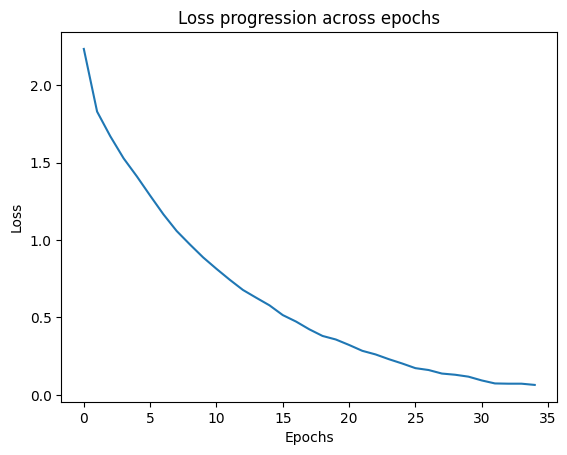

In [56]:

plot_loss(train_losses)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm.

**Question** Fill the code below and train the network!

In [67]:
class ResidualBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()               #here we implement the shortcut connection, aka the mechanism for the skip connection
        if stride != 1 or in_planes != planes:        #first thing to check is if the input and output dimensions are the same, if not we need to add a convolutional layer to the shortcut. If x's shape already matches 𝑜𝑢𝑡 out, the shortcut is just an identity function (nn.Sequential()).
            self.shortcut = nn.Sequential(            #if the dimensions are different we need to add a convolutional layer to the shortcut
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),  #1x1 convolutional layer
                nn.BatchNorm2d(planes)                                                   #batch normalization
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))     #first convolutional layer, then batch normalization, then activation function ReLU
        out = self.bn2(self.conv2(out))           #second convolutional layer, then batch normalization
        out += self.shortcut(x)                   #add the shortcut connection!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        out = F.relu(out)                         #activation function ReLU
        return out  


Epoch 1: Loss=1.8455
Epoch 2: Loss=1.4259
Epoch 3: Loss=1.1918
Epoch 4: Loss=0.9935
Epoch 5: Loss=0.8406
Epoch 6: Loss=0.7296
Epoch 7: Loss=0.6338
Epoch 8: Loss=0.5520
Epoch 9: Loss=0.4987
Epoch 10: Loss=0.4407
Epoch 11: Loss=0.3837
Epoch 12: Loss=0.3399
Epoch 13: Loss=0.3025
Epoch 14: Loss=0.2684
Epoch 15: Loss=0.2252
Epoch 16: Loss=0.1796
Epoch 17: Loss=0.1508
Epoch 18: Loss=0.1343
Epoch 19: Loss=0.1142
Epoch 20: Loss=0.0910
Epoch 21: Loss=0.0850
Epoch 22: Loss=0.0759
Epoch 23: Loss=0.0680
Epoch 24: Loss=0.0672
Epoch 25: Loss=0.0663
Epoch 26: Loss=0.0570
Epoch 27: Loss=0.0476
Epoch 28: Loss=0.0401
Epoch 29: Loss=0.0354
Epoch 30: Loss=0.0389
Epoch 31: Loss=0.0426
Epoch 32: Loss=0.0494
Epoch 33: Loss=0.0485
Epoch 34: Loss=0.0556
Epoch 35: Loss=0.0450
Test set: Avg. loss: 1.1003, Accuracy: 7927/10000 (79%)


(1.100342822265625, tensor(79.2700, device='cuda:0'))

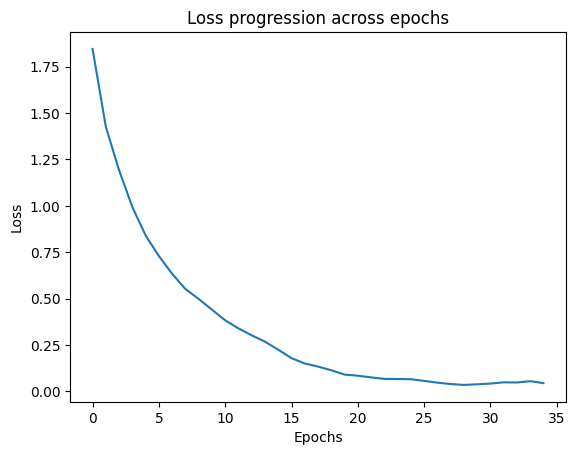

In [68]:
#CONSTANT LEARNING RATE OF 0.01

model = ResNet(block=ResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet and plot the loss
plot_loss(
    fit(model,train_dataloader = train_dataloader,optimizer = optimizer,epochs = 35,device = DEVICE)
)

# predict with the trained model
predict(model,test_dataloader = test_dataloader,device = DEVICE)

### Evaluated! 
**Question:** It looks like the model without the residual connections performs better (3-4%), but on a closer examination of the training curves the residual model achieves lower loss much faster and then plateaus. You might try to add a scheduler to boost the performance!

I did not notice the above-mentioned perfomance drop, that being said I am curious to investigate the implementation of a scheduler to further boost perfomarce!

=== Training and Evaluating Model WITH Skip Connections ===
Epoch 1: Loss=1.8187, Learning Rate=0.100000
Epoch 2: Loss=1.3899, Learning Rate=0.100000
Epoch 3: Loss=1.1911, Learning Rate=0.100000
Epoch 4: Loss=1.0155, Learning Rate=0.100000
Epoch 5: Loss=0.8540, Learning Rate=0.100000
Epoch 6: Loss=0.7407, Learning Rate=0.100000
Epoch 7: Loss=0.6472, Learning Rate=0.100000
Epoch 8: Loss=0.5680, Learning Rate=0.100000
Epoch 9: Loss=0.5138, Learning Rate=0.100000
Epoch 10: Loss=0.4524, Learning Rate=0.100000
Epoch 11: Loss=0.4032, Learning Rate=0.100000
Epoch 12: Loss=0.3615, Learning Rate=0.100000
Epoch 13: Loss=0.3268, Learning Rate=0.100000
Epoch 14: Loss=0.2692, Learning Rate=0.100000
Epoch 15: Loss=0.2374, Learning Rate=0.100000
Epoch 16: Loss=0.1929, Learning Rate=0.100000
Epoch 17: Loss=0.1677, Learning Rate=0.100000
Epoch 18: Loss=0.1420, Learning Rate=0.100000
Epoch 19: Loss=0.1244, Learning Rate=0.100000
Epoch 20: Loss=0.0955, Learning Rate=0.100000
Epoch 21: Loss=0.0704, Learni

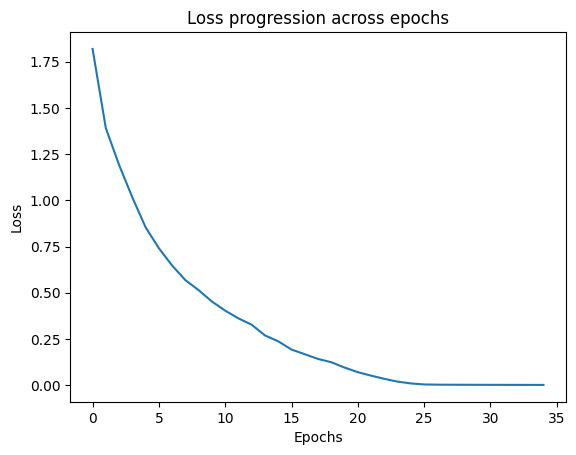

In [70]:
#LEARNING RATE SCHEDULER

model_with_skip = ResNet(block=ResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)

#different optimizer as we need to taylor the learning rate
optimizer_with_skip = optim.SGD(model_with_skip.parameters(), lr=0.1, momentum=0.9)
scheduler_with_skip = optim.lr_scheduler.StepLR(optimizer_with_skip, step_size=25, gamma=0.5)

#tran and print
print("=== Training and Evaluating Model WITH Skip Connections ===")             #new_fit was made for the scheduler!!!!!!!!!!!
train_losses_with_skip = new_fit(
    model=model_with_skip,
    train_dataloader=train_dataloader,
    optimizer=optimizer_with_skip,
    scheduler=scheduler_with_skip,
    epochs=35,
    device=DEVICE
)

#avaluate and plot
print("=== Evaluation WITH Skip Connections ===")
predict(model=model_with_skip, test_dataloader=test_dataloader, device=DEVICE)

plot_loss(train_losses_with_skip)


As can be seen, if we implement a very simple scheduling (after a few tries) we see that over 35 epochs we can reach much better results than with a constant learning rate.